In [1]:
%pylab
%matplotlib inline
import healpy as hp
import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.time import TimeDelta
from astropy.coordinates import get_sun
from functools import reduce

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Frequency extrapolation

In [2]:
T_Hmap = hp.read_map("lambda_haslam408_dsds.fits")  # read_map loads the first column

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/michellemora/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


    Temperature spectral index
    
$$\alpha=-\frac{log(T_1/T_2)}{log(\nu_1/\nu_2)}$$

In [3]:
def T_freq(alpha,freq1,freq2,T1):
    return T1*10**(alpha*log10(freq1/freq2))

### Galactic longitude (l) and latitude (b)

In [4]:
nside = hp.get_nside(T_Hmap)  #nside
npix = hp.nside2npix(nside)   #number of pixels

l, b = hp.pix2ang(nside, arange(npix), lonlat=True)   #(l, b) coordinates for each pixel
g_coord=SkyCoord(l*u.deg, b*u.deg, frame='galactic')  

### Time and location for horizontal coordinates 

In [5]:
Alma_loc = EarthLocation.of_site('ALMA')
start_t=Time('2021-06-14T00:00:00',format='isot')

times30=start_t + TimeDelta(30*60, format='sec')*linspace(0,48,48) #dt=30 min

altaz30 = AltAz(location=Alma_loc, obstime=times30)

### Dynamic Spectra

Temperature matrix for the dynamic spectra

$$T(\nu,t)=\begin{pmatrix}
T(\nu_1,t_m) & T(\nu_2,t_m) & \cdots & T(\nu_n,t_m)\\ 
 \vdots &  \vdots  &\vdots & \vdots  \\ 
T(\nu_1,t_1) & T(\nu_2,t_1) & \cdots & T(\nu_n,t_1)
\end{pmatrix}$$

In [6]:
freqs1=arange(40,111,1)

### Antenna gain

$$g_{phi0}=g_{\phi_0}(\theta,\nu)$$

In [17]:
g_cols=loadtxt('Gain_Blade_nominal_Raul_phi_0.dat',skiprows=2,usecols=arange(1,72))
g_s=g_cols[90:]
Theta=arange(0,91,1)
g_s[:,0]

array([2.69499587e+00, 2.69447366e+00, 2.69290272e+00, 2.69028291e+00,
       2.68661393e+00, 2.68189542e+00, 2.67612693e+00, 2.66930792e+00,
       2.66143781e+00, 2.65251598e+00, 2.64254182e+00, 2.63151473e+00,
       2.61943414e+00, 2.60629959e+00, 2.59211073e+00, 2.57686738e+00,
       2.56056955e+00, 2.54321750e+00, 2.52481181e+00, 2.50535338e+00,
       2.48484355e+00, 2.46328408e+00, 2.44067729e+00, 2.41702606e+00,
       2.39233394e+00, 2.36660518e+00, 2.33984483e+00, 2.31205879e+00,
       2.28325388e+00, 2.25343796e+00, 2.22261994e+00, 2.19080990e+00,
       2.15801916e+00, 2.12426038e+00, 2.08954758e+00, 2.05389628e+00,
       2.01732358e+00, 1.97984819e+00, 1.94149055e+00, 1.90227292e+00,
       1.86221942e+00, 1.82135613e+00, 1.77971115e+00, 1.73731469e+00,
       1.69419915e+00, 1.65039912e+00, 1.60595154e+00, 1.56089568e+00,
       1.51527323e+00, 1.46912835e+00, 1.42250770e+00, 1.37546049e+00,
       1.32803852e+00, 1.28029620e+00, 1.23229054e+00, 1.18408122e+00,
      

(Text(0.5,0,'freqs'), Text(0,0.5,'Gain'))

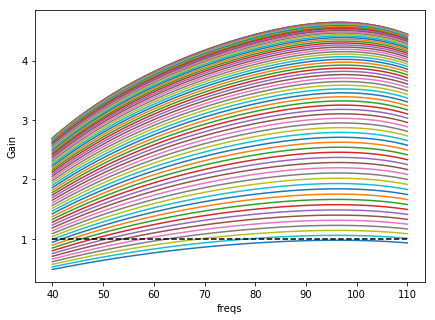

In [8]:
figure(figsize=(7,5))
for i in range(71):
    plot(freqs1,g_s[i]) #Each curve is a different theta
plot([40,110],[1,1],'k--')
xlabel('freqs'),ylabel('Gain')

In [9]:
gn_all=g_s/amax(g_s)   #Normalized to the max value of g for all freqs
max_g=[max(g_s[:,i]) for i in range (71)]
gn_each=g_s/max_g      #Normalize to the max value of g for each freq

(Text(0.5,0,'freqs'), Text(0,0.5,'Gain'))

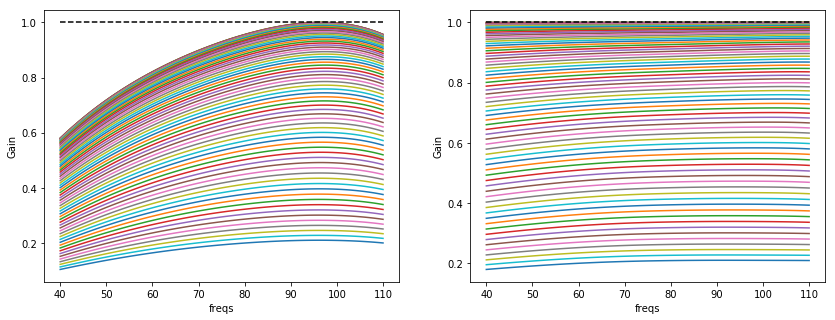

In [10]:
figure(figsize=(14,5))
subplot(1,2,1)
for i in range(71):
    plot(freqs1,gn_all[i]) #Each curve is a different theta
plot([40,110],[1,1],'k--')
xlabel('freqs'),ylabel('Gain')
subplot(1,2,2)
for i in range(71):
    plot(freqs1,gn_each[i]) #Each curve is a different theta
plot([40,110],[1,1],'k--')
xlabel('freqs'),ylabel('Gain')

In [11]:
def Temps(fs,ts):  
    '''Takes frequencies (fs) and times in AltAz frame (ts) and returns the Temperature matrix'''
    
    start = time.time()
    Temps=zeros((ts.obstime.size,len(fs)))
    for i in range (ts.obstime.size):
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        for j in range (len(fs)):
            T_f=T_freq(2.54,408,fs[j],T_sky)      #Extrapolation
            Temps[-i,j]=mean(T_f)                 #Mean temperature (bottom to top)
    end = time.time()
    print('Tiempo recorrido(s):',end - start)  
    return Temps

## Prueba 1: g_norm sin promedio

In [36]:
def Temps_gain1(fs,ts,g_phi0):  
    '''Takes frequencies (fs) and times in AltAz frame (ts) and returns the Temperature + Gain matrix'''
    
    start = time.time()
    Temps_g=zeros((ts.obstime.size,len(fs))) 
    for i in range (ts.obstime.size): 
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    ##Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   ##Int value (dTheta=1deg)
        
        for j in range (len(fs)):    
            gain=g_phi0[Th,j]          ###Gains for Th to use and freq_j in same order as Tsky  
            T_sky_g=gain*T_sky                            ##New T_sky with respective gain
            
            T_f_g=T_freq(2.54,408,fs[j],T_sky_g)          #Extrapolation
            Temps_g[-i,j]=mean(T_f_g)                     #Mean temperature (bottom to top)
            
    end = time.time()
    print('Tiempo recorrido(s):',end - start)  
    return Temps_g

In [37]:
T_Gnall1=Temps_gain1(freqs1,altaz30,gn_all)      #Dynamic spectra with gain pattern (norm all freqs)

Tiempo recorrido(s): 322.72019624710083


In [38]:
T_Gneach1=Temps_gain(freqs1,altaz30,gn_each)      #Dynamic spectra with gain pattern (norm each freqs)

Tiempo recorrido(s): 316.1454358100891


In [ ]:
figure(figsize=(16,7))
subplot(1,3,1)
pcolormesh(freqs1,times30.to_datetime(), T,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("Without gain pattern (dfreq=1 MHz, dt=30 min)"),xlabel('freq (MHz)')
subplot(1,3,2)
pcolormesh(freqs1,times30.to_datetime(), T_Gnall,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern (norm all freqs)")
xlabel('freq (MHz)')
subplot(1,3,3)
pcolormesh(freqs1,times30.to_datetime(), T_Gneach,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern (norm each freq)")
xlabel('freq (MHz)')

## Prueba 2: g_norm/mean(g_norm)

In [12]:
def Temps_gain(fs,ts,g_phi0):  
    '''Takes frequencies (fs) and times in AltAz frame (ts) and returns the Temperature + Gain matrix'''
    
    start = time.time()
    Temps_g=zeros((ts.obstime.size,len(fs))) 
    for i in range (ts.obstime.size): 
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    ##Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   ##Int value (dTheta=1deg)
        
        for j in range (len(fs)):    
            gain=g_phi0[Th,j]/mean(g_phi0[Th,j])          ###Gains for Th to use and freq_j in same order as Tsky  
            T_sky_g=gain*T_sky                            ##New T_sky with respective gain
            
            T_f_g=T_freq(2.54,408,fs[j],T_sky_g)          #Extrapolation
            Temps_g[-i,j]=mean(T_f_g)                     #Mean temperature (bottom to top)
            
    end = time.time()
    print('Tiempo recorrido(s):',end - start)  
    return Temps_g

In [13]:
T=Temps(freqs1,altaz30)             #Dynamic spectra without gain pattern

Tiempo recorrido(s): 263.82337403297424


In [14]:
T_Gnall=Temps_gain(freqs1,altaz30,gn_all)      #Dynamic spectra with gain pattern (norm all freqs)

Tiempo recorrido(s): 397.05917406082153


In [15]:
T_Gneach=Temps_gain(freqs1,altaz30,gn_each)      #Dynamic spectra with gain pattern (norm each freqs)

Tiempo recorrido(s): 400.7542588710785


In [94]:
shape(T),shape(T_Gnall)

((48, 101), (48, 71))

Text(0.5,0,'freq (MHz)')

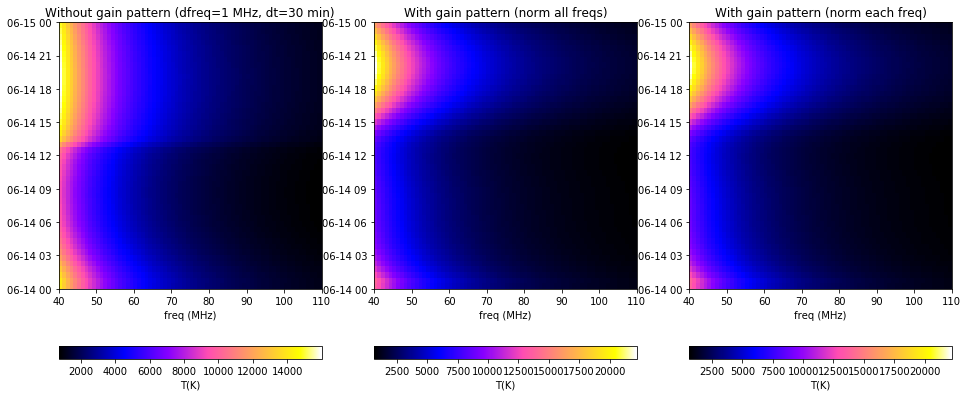

In [16]:
figure(figsize=(16,7))
subplot(1,3,1)
pcolormesh(freqs1,times30.to_datetime(), T,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("Without gain pattern (dfreq=1 MHz, dt=30 min)"),xlabel('freq (MHz)')
subplot(1,3,2)
pcolormesh(freqs1,times30.to_datetime(), T_Gnall,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern (norm all freqs)")
xlabel('freq (MHz)')
subplot(1,3,3)
pcolormesh(freqs1,times30.to_datetime(), T_Gneach,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern (norm each freq)")
xlabel('freq (MHz)')

(40, 50)

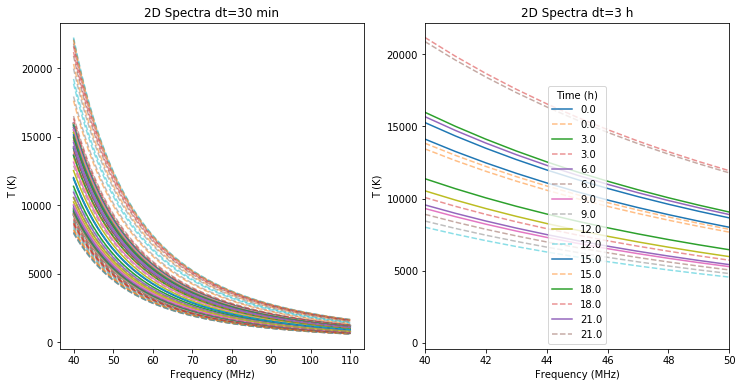

In [18]:
figure(figsize=(12,6))
subplot(1,2,1)
title('2D Spectra dt=30 min')
for i in range (0,len(times30)):
    plot(freqs1,T[i])
    plot(freqs1,T_Gnall[i],'--',alpha=0.5)
xlabel('Frequency (MHz)'),ylabel('T (K)')
subplot(1,2,2)
title('2D Spectra dt=3 h')
for i in range (0,len(times30),6):    
    plot(freqs1,T[i],label=i/2)
    plot(freqs1,T_Gnall[i],'--',alpha=0.5,label=i/2)
    
legend(title='Time (h)')
xlabel('Frequency (MHz)'),ylabel('T (K)')
xlim(40,50)

In [19]:
import pandas as pd
fig1=pd.read_csv('figure1_plotdata.csv',names=['Freq','Weight','Tsky','Tres1','Tres2','Tmodel','T21'],skiprows=4,skipfooter=2,engine='python')
#fig1[:10]

(Text(0.5,0,'freq(MHz)'), Text(0,0.5,'T(K)'))

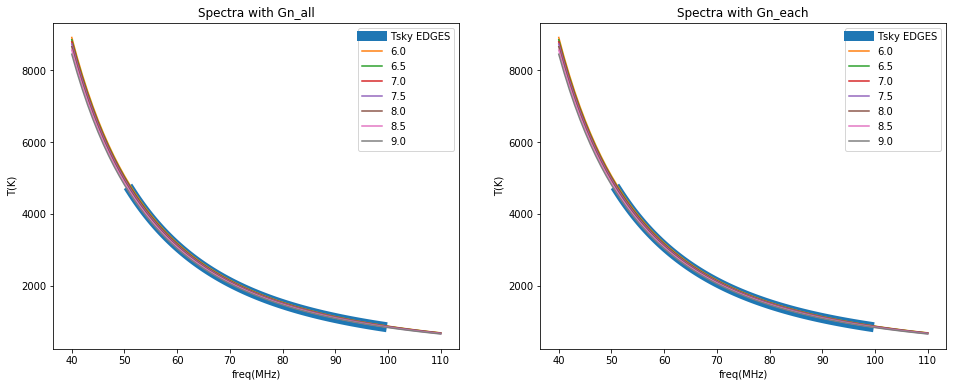

In [23]:
figure(figsize=(16,6))
subplot(1,2,1)
title('Spectra with Gn_all')
plot(fig1['Freq'],fig1['Tsky'],linewidth=10,label='Tsky EDGES')
t=12
while t!=19:
    plot(freqs1,T_Gnall[t],label=t/2)
    t+=1
xlabel('freq(MHz)'),ylabel('T(K)')
legend()
subplot(1,2,2)
title('Spectra with Gn_each')
plot(fig1['Freq'],fig1['Tsky'],linewidth=10,label='Tsky EDGES')
t=12
while t!=19:
    plot(freqs1,T_Gneach[t],label=t/2)
    t+=1
legend()
xlabel('freq(MHz)'),ylabel('T(K)')

## Prueba 2: g_norm/mean(g(f_fija))

In [26]:
def Temps_gain2(fs,ts,g_phi0):  
    '''Takes frequencies (fs) and times in AltAz frame (ts) and returns the Temperature + Gain matrix'''
    
    start = time.time()
    Temps_g=zeros((ts.obstime.size,len(fs))) 
    for i in range (ts.obstime.size): 
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    ##Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   ##Int value (dTheta=1deg)
        
        for j in range (len(fs)):    
            gain=g_phi0[Th,j]/mean(g_s[Th,j])             ###Gains for Th to use and freq_j in same order as Tsky  
            T_sky_g=gain*T_sky                            ##New T_sky with respective gain
            
            T_f_g=T_freq(2.54,408,fs[j],T_sky_g)          #Extrapolation
            Temps_g[-i,j]=mean(T_f_g)                     #Mean temperature (bottom to top)
            
    end = time.time()
    print('Tiempo recorrido(s):',end - start)  
    return Temps_g

In [27]:
T_Gnall2=Temps_gain2(freqs1,altaz30,gn_all)      #Dynamic spectra with gain pattern (norm all freqs)

Tiempo recorrido(s): 438.078547000885


In [28]:
T_Gneach2=Temps_gain2(freqs1,altaz30,gn_each)      #Dynamic spectra with gain pattern (norm each freqs)

Tiempo recorrido(s): 413.0417709350586


Text(0.5,0,'freq (MHz)')

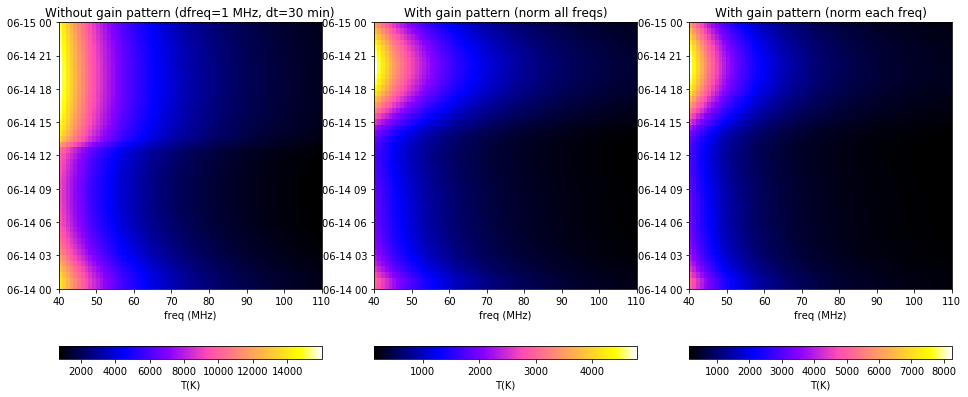

In [30]:
figure(figsize=(16,7))
subplot(1,3,1)
pcolormesh(freqs1,times30.to_datetime(), T,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("Without gain pattern (dfreq=1 MHz, dt=30 min)"),xlabel('freq (MHz)')
subplot(1,3,2)
pcolormesh(freqs1,times30.to_datetime(), T_Gnall2,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern (norm all freqs)")
xlabel('freq (MHz)')
subplot(1,3,3)
pcolormesh(freqs1,times30.to_datetime(), T_Gneach2,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern (norm each freq)")
xlabel('freq (MHz)')

(Text(0.5,0,'freq(MHz)'), Text(0,0.5,'T(K)'))

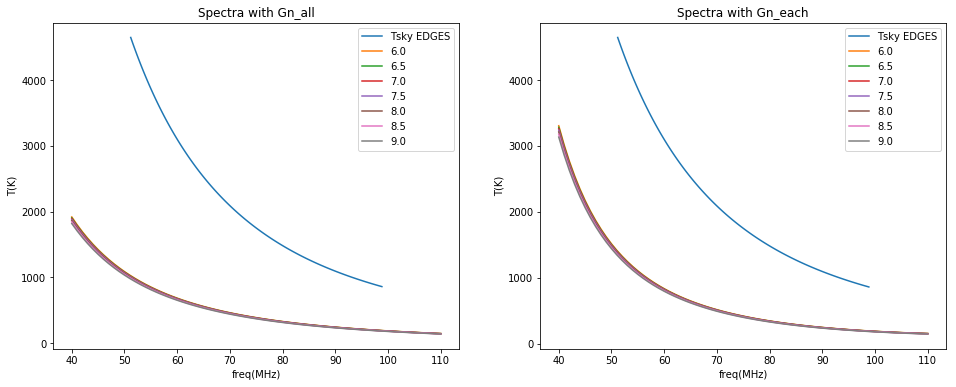

In [34]:
figure(figsize=(16,6))
subplot(1,2,1)
title('Spectra with Gn_all')
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
t=12
while t!=19:
    plot(freqs1,T_Gnall2[t],label=t/2)
    t+=1
xlabel('freq(MHz)'),ylabel('T(K)')
legend()
subplot(1,2,2)
title('Spectra with Gn_each')
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
t=12
while t!=19:
    plot(freqs1,T_Gneach2[t],label=t/2)
    t+=1
legend()
xlabel('freq(MHz)'),ylabel('T(K)')

# RESUMEN

In [78]:
horas=linspace(0,24,48)

Text(0.5,0,'freq (MHz)')

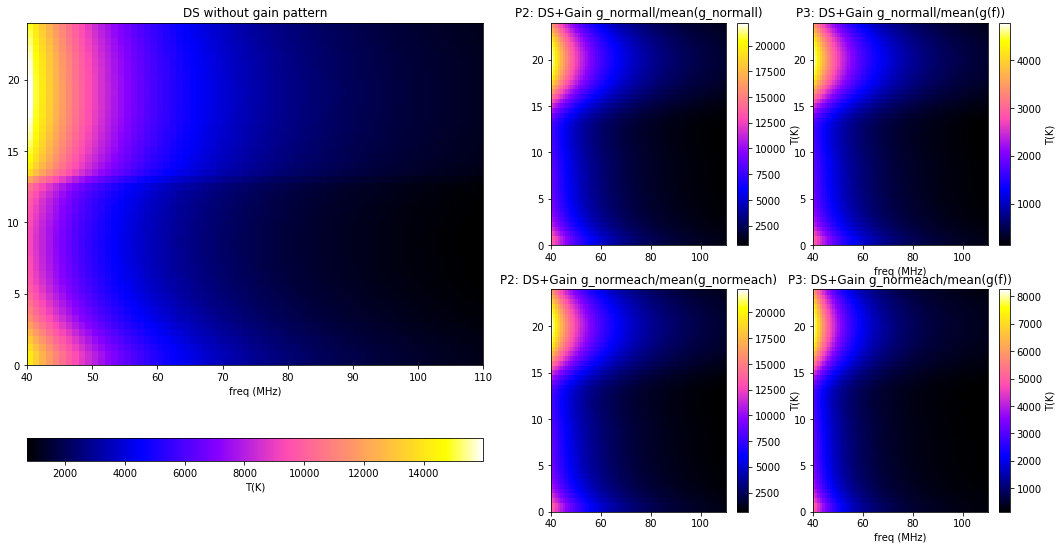

In [108]:
figure(figsize=(18,9))
subplot(1,2,1)
pcolormesh(freqs1,horas, T,cmap='gnuplot2')
colorbar(label='T(K)',orientation='horizontal')
title("DS without gain pattern"),xlabel('freq (MHz)')
subplot(2,4,3)
pcolormesh(freqs1,horas, T_Gnall,cmap='gnuplot2')
colorbar(label='T(K)')
title("P2: DS+Gain g_normall/mean(g_normall)")
subplot(2,4,7)
pcolormesh(freqs1,horas, T_Gneach,cmap='gnuplot2')
colorbar(label='T(K)')
title("P2: DS+Gain g_normeach/mean(g_normeach)")
subplot(2,4,4)
pcolormesh(freqs1,horas, T_Gnall2,cmap='gnuplot2')
colorbar(label='T(K)')
title("P3: DS+Gain g_normall/mean(g(f))")
xlabel('freq (MHz)')
subplot(2,4,8)
pcolormesh(freqs1,horas, T_Gneach2,cmap='gnuplot2')
colorbar(label='T(K)')
title("P3: DS+Gain g_normeach/mean(g(f))")
xlabel('freq (MHz)')

/Users/michellemora/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


([[<matplotlib.lines.Line2D at 0x130c1e278>],
 <matplotlib.legend.Legend at 0x132e61630>)

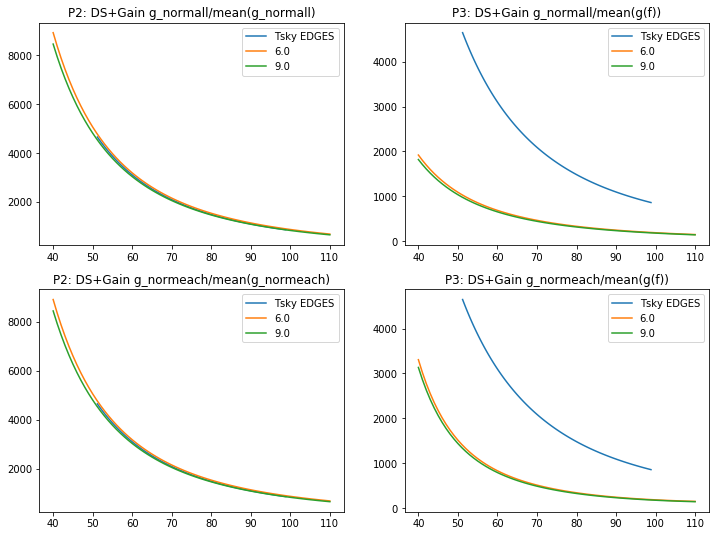

In [131]:
figure(figsize=(12,9))
for i in range (1,5):
    subplot(2,2,i)
    plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
    legend()
subplot(2,2,1)
title('P2: DS+Gain g_normall/mean(g_normall)')
[plot(freqs1,T_Gnall[i],label=i/2) for i in ([12,18])],legend()
subplot(2,2,3)
title('P2: DS+Gain g_normeach/mean(g_normeach)')
[plot(freqs1,T_Gneach[i],label=i/2) for i in ([12,18])],legend()
subplot(2,2,2)
title('P3: DS+Gain g_normall/mean(g(f))')
[plot(freqs1,T_Gnall2[i],label=i/2) for i in ([12,18])],legend()
subplot(2,2,4)
title('P3: DS+Gain g_normeach/mean(g(f))')
[plot(freqs1,T_Gneach2[i],label=i/2) for i in ([12,18])],legend()

0